# Smart Beta and Factor Investing

## 2. The Factors

# Data

Use the data found in `data/factor_pricing_data.xlsx`.

**Factors:** Monthly excess return data for the overall equity market, $\tilde{r}^{MKT}$.

- The column header to the market factor is `MKT` rather than `MKT-RF`, but it is indeed already in excess return form.
- The sheet also contains data on five additional factors.
- All factor data is already provided as excess returns.


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

#read data
factors = pd.read_excel("data/dfa_analysis_data.xlsx", sheet_name="factors").drop('RF', axis=1)
factors.set_index('Date',inplace=True)
tot_ret = pd.read_excel("data/dfa_analysis_data.xlsx", sheet_name="portfolios (total returns)")
tot_ret.set_index('Date',inplace=True)
factors.head(5)

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

FREQ = 12 # Annualization factor since we have monthly data
#read data
factors = pd.read_excel("data/factor_pricing_data_monthly.xlsx", sheet_name="factors (excess returns)")
factors.set_index('Date',inplace=True)

factors.head()

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118


## 1.

Analyze the factors, similar to how you analyzed the three Fama-French factors in `Homework 4`.

You now have three additional factors, so let’s compare their univariate statistics.

- mean  
- volatility  
- Sharpe

In [55]:
# Helper function
def calc_stats(rets, FREQ):
    mean = rets.mean() * FREQ
    vol = rets.std() * np.sqrt(FREQ)
    sharpe = mean / vol
    results = {'Mean' : mean, 'Volatility' : vol, 'Sharpe' : sharpe}
    return pd.DataFrame(results)

In [56]:
# Helper function
def display_df(df, decimals):
    # display in percentages
    display(df.style.format(f"{{:.{decimals}%}}"))


In [57]:
# Main code
stats = calc_stats(factors, FREQ)
display_df(stats, 2)


,Mean,Volatility,Sharpe
MKT,8.76%,15.61%,56.07%
SMB,0.61%,10.13%,6.04%
HML,2.60%,10.88%,23.92%
RMW,4.40%,8.29%,53.11%
CMA,2.83%,7.25%,39.03%
UMD,6.03%,15.34%,39.33%


## 2.

Based on the factor statistics above, answer the following.

- Does each factor have a positive risk premium (positive expected excess return)?

- How have the factors performed since the time of the case (2015–present)?

In [58]:
# Code for post 2015 stats analysis
factors_post_2015 = factors.loc['2015-01-01':]
post_2015_stats = calc_stats(factors_post_2015, FREQ)
display_df(post_2015_stats, 2)

,Mean,Volatility,Sharpe
MKT,11.79%,15.74%,74.91%
SMB,-2.38%,10.32%,-23.05%
HML,-1.63%,12.99%,-12.55%
RMW,4.00%,7.26%,55.09%
CMA,-0.91%,8.21%,-11.14%
UMD,2.01%,13.74%,14.64%


* All six factors had positive average excess returns over the full period — i.e., positive risk premia.

* Factor performance Since 2015
    * Only MKT, RMW and UMD have remained positive 
    * SMB, HML and CMA have shown a negative risk permium

However, when considering the Sharpe ratio, only MKT and RMW have delivered stronger risk-adjusted performance than in the full-sample period.

## 3.

Report the correlation matrix across the six factors.

- Does the construction method succeed in keeping correlations small?

- Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

In [59]:
# Helper function to plot a corr matrix of returns
def plot_correlation_matrix(rets):
    corr = rets.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        corr,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        vmin=-1, vmax=1,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8, "label": "Correlation"}
    )
    plt.title("Factor Correlation Matrix", fontsize=14, pad=10)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

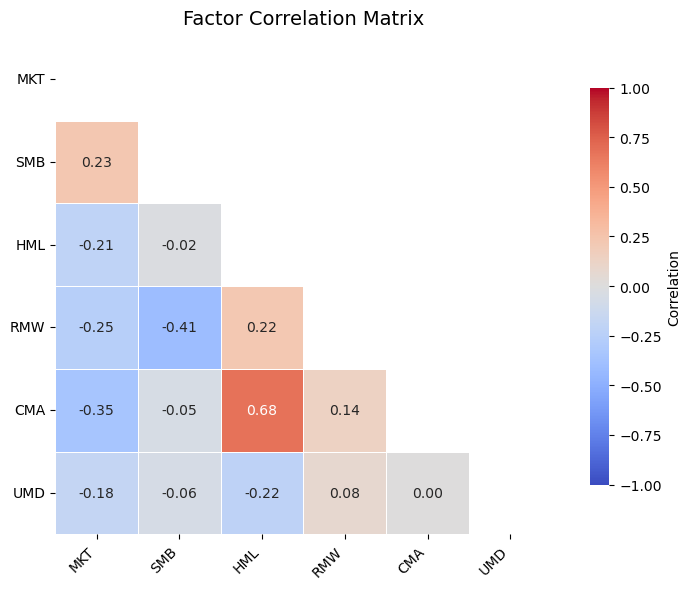

In [60]:
plot_correlation_matrix(factors)

- The factor correlations are generally low, indicating that the construction method successfully keeps the factors distinct. 
The only noticeable correlation is between **CMA** and **HML** (≈ 0.68), while most others are close to zero or slightly negative.
This suggests that the factors capture different sources of risk, providing good diversification.  
- **HML** is not redundant. It remains weakly correlated with most factors, except **CMA**, which is acceptable given their similar value and investment focus.


### 4. Tangency Portfolio of Factors

Report the **tangency weights** for a portfolio of these six factors.

- Which factors seem most important? And least?
- Are the factors with low mean returns still useful?
- Re-do the tangency portfolio, but this time only include **MKT**, **SMB**, **HML**, and **UMD**.  
  Which factors get high or low tangency weights now?

What do you conclude about the importance or unimportance of these styles?


In [61]:
def tangency_weights(rets, FREQ):
    columns = rets.columns
    Sigma = rets.cov().values
    mu = rets.mean().values

    unscaled_weights = np.linalg.pinv(Sigma) @ mu
    weights = unscaled_weights / unscaled_weights.sum()

    return pd.Series(weights, index= columns)

In [62]:
def plot_weights(weights, title, color='skyblue'):
    plt.figure(figsize=(8,4))
    plt.bar(weights.index, weights.values, color=color, edgecolor='black')
    plt.title(title)
    plt.ylabel("Weight")
    plt.xlabel("Factor")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [63]:
def plot_comparison(combined_df, title="Tangency Portfolio Comparison", colors=('skyblue', 'salmon')):
    plt.figure(figsize=(8,4))
    combined_df.plot(kind='bar', color=colors, edgecolor='black', figsize=(8,4))
    plt.title(title)
    plt.ylabel("Weight")
    plt.xlabel("Factor")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title="Portfolio")
    plt.tight_layout()
    plt.show()

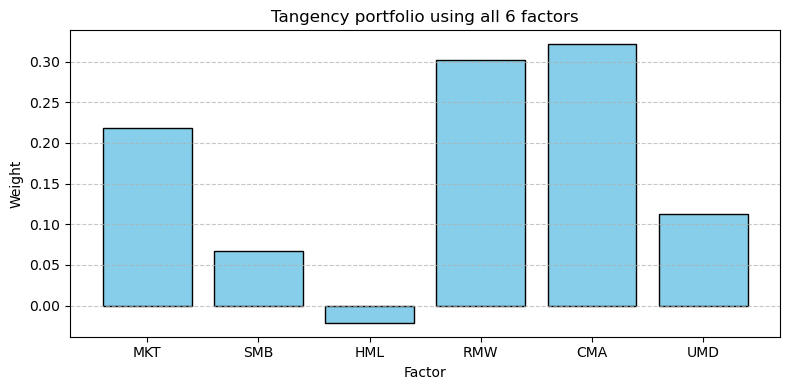

In [64]:
weights_6_factors = tangency_weights(factors, 12)
plot_weights(weights_6_factors, 'Tangency portfolio using all 6 factors')


- **MKT**, **RMW**, and **CMA** have the largest weights in the 6-factor tangency portfolio, indicating they are the most important contributors to risk-adjusted performance.   **UMD**, **HML**, and **SMB** have smaller weights, suggesting they play a minor role in improving portfolio efficiency.


- Factors with low mean returns can still provide valuable diversification benefits. For example, **CMA** has a relatively low mean return (around 2.83%) but receives a high weight in the tangency portfolio, indicating it improves the portfolio’s overall risk-adjusted performance.


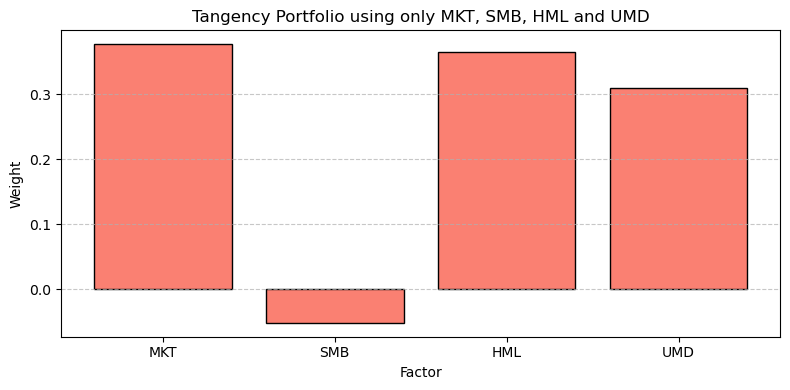

In [65]:
weights_4_factors = tangency_weights(factors[['MKT', 'SMB', 'HML', 'UMD']], 12)
plot_weights(weights_4_factors, 'Tangency Portfolio using only MKT, SMB, HML and UMD', 'salmon')


- After reducing the tangency portfolio to only 4 factors (**MKT**, **SMB**, **HML**, and **UMD**), the weights shift toward **HML** and slightly toward **MKT** and **UMD**. **SMB** decreases sharply and even takes a small negative weight, indicating that the size factor contributes little to the portfolio’s risk-adjusted performance in this restricted set.


<Figure size 800x400 with 0 Axes>

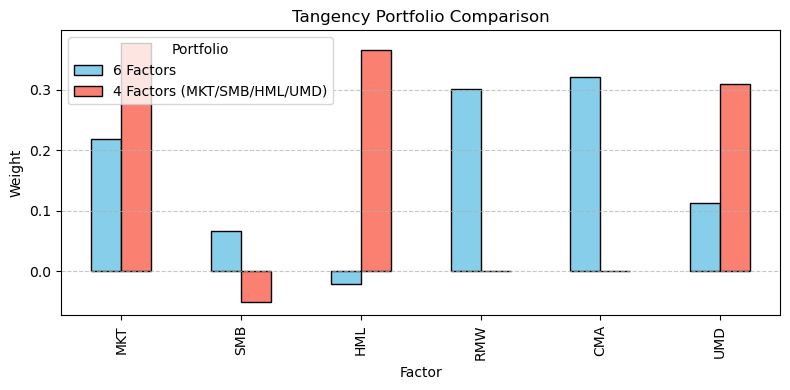

In [66]:
combined_weights_df =  pd.concat([weights_6_factors.rename("6 Factors"),weights_4_factors.rename("4 Factors (MKT/SMB/HML/UMD)")], axis=1)
plot_comparison(combined_weights_df)

### Conclusion

- The most important styles are **MKT**, **RMW**, and **CMA**, as they consistently receive the highest weights in the tangency portfolio.  
    - These factors contribute the most to improving the portfolio’s Sharpe ratio, indicating strong and distinct sources of risk premia.  
- **HML**, **SMB**, and **UMD** appear less important, as they receive small or even negative weights, suggesting limited incremental benefit once other factors are included.  
- Overall, profitability (**RMW**) and investment (**CMA**) factors play a key role in enhancing portfolio efficiency, while traditional size and value factors (**SMB**, **HML**) add less value in the recent period.


## 3. Testing Modern LPMS

Consider the following factor models:

- **CAPM:** MKT  
- **Fama-French 3F:** MKT, SMB, HML  
- **Fama-French 5F:** MKT, SMB, HML, RMW, CMA  
- **AQR:** MKT, HML, RMW, UMD  

Our labeling of the last model as the **AQR** model is just for concreteness.  
The firm is well-known for these factors, and an unused case study discusses that further.

For instance, for the AQR model:

\[
E[r^i] = \beta_i^{MKT} E[f^{MKT}] + \beta_i^{HML} E[f^{HML}] + \beta_i^{RMW} E[f^{RMW}] + \beta_i^{UMD} E[f^{UMD}]
\]

We will test these models using time-series regressions.  
Namely, for each asset *i*, we estimate the following regression to test the AQR model:

\[
r_t^i = \alpha^i + \beta_i^{MKT} f_t^{MKT} + \beta_i^{HML} f_t^{HML} + \beta_i^{RMW} f_t^{RMW} + \beta_i^{UMD} f_t^{UMD} + \varepsilon_t
\]


### Data

- Monthly excess return data on **n = 49** equity portfolios sorted by their industry.  
  Denote these as \( r_t^i \), for \( i = 1, \dots, n \).  
- You do **not** need the risk-free rate data. It is provided only for completeness.  
- The other two tabs are already in terms of **excess returns**.


In [70]:
portfolio_rets = pd.read_excel("data/factor_pricing_data_monthly.xlsx", sheet_name="portfolios (excess returns)")
portfolio_rets.set_index('Date',inplace=True)
portfolio_rets.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,-0.0073,0.0285,0.0084,0.1009,-0.0143,0.0995,0.0348,0.0323,0.0048,0.0059,...,0.0158,0.0851,0.0466,-0.0125,0.0430,-0.0284,0.0254,0.0770,0.0306,0.0666
1980-02-29,0.0125,-0.0609,-0.0967,-0.0323,-0.0575,-0.0316,-0.0492,-0.0803,-0.0556,-0.0169,...,-0.0083,-0.0543,-0.0345,-0.0641,-0.0653,-0.0824,-0.0960,-0.0352,-0.0283,-0.0273
1980-03-31,-0.2220,-0.1119,-0.0158,-0.1535,-0.0188,-0.1272,-0.0827,-0.1238,-0.0567,-0.0670,...,-0.0819,-0.1512,-0.1602,-0.0905,-0.1450,-0.0559,-0.0877,-0.2449,-0.1261,-0.1737
1980-04-30,0.0449,0.0767,0.0232,0.0289,0.0830,-0.0529,0.0785,0.0154,0.0305,0.0115,...,0.0422,-0.0102,0.0268,0.0355,0.0539,0.0736,0.0528,0.0964,0.0458,0.0784
1980-05-31,0.0635,0.0797,0.0458,0.0866,0.0822,0.0510,0.0325,0.0888,0.0560,0.0098,...,0.0564,0.1065,0.1142,0.0877,0.1104,0.0570,0.0560,0.0889,0.0846,0.0663


### 1.

Test the **AQR 4-Factor Model** using the time-series test.  
(We are not doing the cross-sectional regression tests.)

For each regression, report the estimated **α** (alpha) and **R²**.


In [92]:
AQR_FACTORS = ['MKT', 'HML', 'RMW', 'UMD']
CAPM_FACTORS = ['MKT']
FF3_FACTORS = ['MKT', 'SMB', 'HML']
FF5_FACTORS = ['MKT', 'SMB', 'HML', 'RMW', 'CMA']

In [ ]:
def calc_alphas_and_rsquared(portfolio_rets, factor_rets, freq, base_factors):
    X = sm.add_constant(factor_rets[base_factors])
    alphas = []
    r2_values = []
    for industry in portfolio_rets.columns:
        y = portfolio_rets[industry]
        model = sm.OLS(y,X).fit()
        alpha = model.params['const'] * freq
        r2 = model.rsquared
        alphas.append(alpha)
        r2_values.append(r2)

    results = pd.DataFrame({'alpha' : alphas, 'r-squared' : r2_values}, index=portfolio_rets.columns)
    return results

In [83]:
def display_top_n(df, column_name, no_rows):
    results = df.loc[df[column_name].abs().nlargest(10).index]
    display_df(results, 2)


In [86]:
aqr_results = calc_alphas_and_rsquared(portfolio_rets, factors, 12, AQR_FACTORS)
#display_df(aqr_results, 2) #-- Dsiplay all
display_top_n(aqr_results, 'alpha', 10) # -- Display top n based on absolute value of alpha

,alpha,r-squared
Softw,6.84%,74.50%
Chips,6.36%,74.98%
RlEst,-5.11%,60.54%
PerSv,-4.96%,58.48%
Paper,-4.30%,67.30%
Other,-4.22%,58.37%
Hardw,4.20%,66.69%
Smoke,4.11%,26.54%
Hlth,-4.07%,44.09%
Coal,-3.96%,21.26%


### 2. Mean Absolute Error of Alphas

Compute the mean absolute error (MAE) of the estimated alphas:

$$
\mathrm{MAE} \;=\; \frac{1}{n}\sum_{i=1}^{n}\left|\hat{\alpha}_i\right|
$$

- If the pricing model worked, should these alpha estimates be large or small? Why?
- Based on your MAE statistic, does this seem to support the pricing model or not?


In [89]:
aqr_mae = aqr_results['alpha'].abs().mean()
print(f"Mean Absolute Alpha (MAE): {aqr_mae:.3%}")

Mean Absolute Alpha (MAE): 2.461%


- If the pricing model worked perfectly, the estimated alphas should be **close to zero**, since the factors would fully explain all portfolio returns.  
- In this case, the mean absolute alpha is approximately **2.46%**, which suggests that while the model explains much of the variation in returns, there are still small pricing errors remaining.  
- Overall, this **supports the model reasonably well**, as the yearly alphas are fairly low and do not indicate systematic mispricing across portfolios.


## 2.

Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model.

- Report the MAE statistic for each of these models and compare it with the AQR Model MAE.

- Which model fits best?

In [96]:
capm_results = calc_alphas_and_rsquared(portfolio_rets, factors, 12, CAPM_FACTORS)
ff3_results  = calc_alphas_and_rsquared(portfolio_rets, factors, 12, FF3_FACTORS)
ff5_results  = calc_alphas_and_rsquared(portfolio_rets, factors, 12, FF5_FACTORS)

capm_mae = capm_results['alpha'].abs().mean()
ff3_mae  = ff3_results['alpha'].abs().mean()
ff5_mae  = ff5_results['alpha'].abs().mean()

# Combine results in one DataFrame
all_mae = pd.DataFrame({'Model': ['CAPM', 'FF3', 'FF5', 'AQR'], 'Mean Absolute Alpha (MAE)': [capm_mae, ff3_mae, ff5_mae, aqr_mae]})

display(all_mae.style.format({'Mean Absolute Alpha (MAE)': '{:.2%}'}))

,Model,Mean Absolute Alpha (MAE)
0,CAPM,2.10%
1,FF3,2.44%
2,FF5,3.14%
3,AQR,2.46%


The CAPM model has the lowest MAE (2.10%), meaning it fits the data best in this case.  
The FF3 and AQR models are close behind, while the FF5 model performs the worst.  
Overall, all models fit reasonably well.